In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'retina'

In [2]:
"""
This is a test of spectra generation with pspy and namaster for spin0 fields.
It is done in HEALPIX pixellisation
"""
import matplotlib
from pspy import so_map,so_window,so_mcm,sph_tools,so_spectra, pspy_utils
import healpy as hp, numpy as np, pylab as plt
import os
import pymaster as nmt

## Generate Maps/Masks, Compute NaMaster

In [3]:
#We  specify the HEALPIX survey parameter, it will be a disk of radius 25 degree centered on longitude 30 degree and latitude 50 degree
# It will have a resolution nside=1024
lon,lat=30,50
radius=100
nside=512
# ncomp=1 mean that we are going to use only spin0 field (ncomp=3 for spin 0 and 2 fields
ncomp=1
# clfile are the camb lensed power spectra
clfile='../../data/bode_almost_wmap5_lmax_1e4_lensedCls_startAt2.dat'
# a binningfile with format, lmin,lmax,lmean
binning_file='../../data/binningFile_100_50.dat'
# the maximum multipole to consider
lmax=3*nside-1
# the number of iteration in map2alm
niter=3
# the noise on the spin0 component
rms_uKarcmin_T=20
# the apodisation lengh for the survey mask (in degree)
apo_radius_degree_survey=1
# the number of holes in the point source mask
source_mask_nholes=100
# the radius of the holes (in arcminutes)
source_mask_radius=10
# the apodisation lengh for the point source mask (in degree)
apo_radius_degree_mask=0.3
# the type of power spectrum (Cl or Dl)
type='Cl'

test_dir='result_pspyVSnamaster_spin0'
try:
    os.makedirs(test_dir)
except:
    pass

# the templates for the CMB splits
template= so_map.healpix_template(ncomp,nside=nside)
# the templates for the binary mask
binary=so_map.healpix_template(ncomp=1,nside=nside)
# we set pixel inside the disk at 1 and pixel outside at zero
vec=hp.pixelfunc.ang2vec(lon,lat, lonlat=True)
disc=hp.query_disc(nside, vec, radius=radius*np.pi/180)
binary.data[disc]=1

#First let's generate a CMB realisation
cmb=template.synfast(clfile)
split=cmb.copy()
#let's add noise to it with rms 20 uk.arcmin
noise = so_map.white_noise(split,rms_uKarcmin_T=rms_uKarcmin_T)
split.data+=noise.data

#we then apodize the survey mask
window=so_window.create_apodization(binary, apo_type='C1', apo_radius_degree=apo_radius_degree_survey)
#we create a point source mask
mask=so_map.simulate_source_mask(binary, nholes=source_mask_nholes, hole_radius_arcmin=source_mask_radius)
#... and we apodize it
mask= so_window.create_apodization(mask, apo_type='C1', apo_radius_degree=apo_radius_degree_mask)
#the window is given by the product of the survey window and the mask window
window.data*=mask.data

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [26]:
def get_bonus_bins(width=5, top_ell=30):
    bonus_bin_left, bonus_bin_right = [], []
    counter = 0
    for i in list(range(1,top_ell))[::-1]:
        counter += 1
        if counter % width == 0:
            bonus_bin_left.append(i)
            bonus_bin_right.append(i+width-1)
        elif i == 2:
            bonus_bin_left.append(i)
            bonus_bin_right.append(width-1)
    return bonus_bin_left[::-1], bonus_bin_right[::-1]

In [29]:
lb_d = {}
Cb_d = {}
for w in [1, 2, 5, 10]:
    bonus_left, bonus_right = get_bonus_bins(w)
    binleft, binright = np.genfromtxt('planck_spectra/binused.dat', 
                                              unpack=True, usecols=(0,1), dtype=((int), (int)))
    

    binleft, binright = np.hstack((bonus_left,binleft)), np.hstack((bonus_right,binright))
    ells = np.arange(3*nside)
    bpws = -1+np.zeros_like(ells) #Array of bandpower indices
    for i, (bl, br) in enumerate(zip(binleft, binright)):
        bpws[bl:br+1] = i
    weights = np.array([1 for l in ells])
    b = nmt.NmtBin(nside, bpws=bpws, ells=ells, weights=weights, lmax=lmax, is_Dell=False)
    lb = b.get_effective_ells()


    # Compute spin 0 spectra a la namaster
    # nlb=50
    field=nmt.NmtField(window.data,[split.data])
    cl_coupled=nmt.compute_coupled_cell(field,field)
    # b=nmt.NmtBin(nside,nlb=nlb)
    # lb=b.get_effective_ells()
    w0=nmt.NmtWorkspace()
    w0.compute_coupling_matrix(field,field,b)
    Cb_namaster=w0.decouple_cell(cl_coupled)
    lb_d[str(w)] = lb
    Cb_d[str(w)] = Cb_namaster[0]

(-0.1, 0.1)

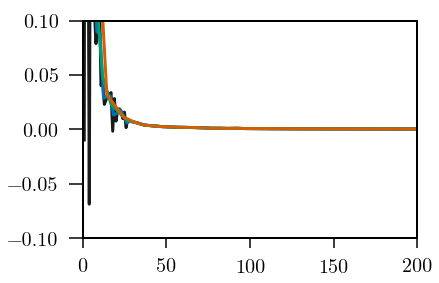

In [51]:
l_ref, Cl_ref, _, _, _ = np.genfromtxt(clfile, unpack=True)

for w in [1, 2, 5, 10]:
    lb, Cb = lb_d[str(w)], Cb_d[str(w)]
    
    plt.plot( (lb), Cb / Cl_ref[lb.astype(int)] )
plt.xlim(0,200)
plt.ylim(-0.1, 0.1)